## Import Library

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer,LabelEncoder
from sklearn.model_selection import train_test_split
import lightgbm as lgbm
from lightgbm import LGBMClassifier
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')
pd.set_option('Display.max_columns',100)
pd.set_option('Display.max_rows',100)

## Import Dataset

In [3]:
# Read csv file
path    = "../final_assignment_public/Telecom_customer_churn.csv"
df      = pd.read_csv( path )

print( 'df:\n{} rows × {} columns\n'.format( df.shape[0], df.shape[1] ) )

df:
100000 rows × 100 columns



## Data Preprocessing

In [4]:
def check_null( _df ):
    print( _df.isnull().sum() )

### Feature engineering

In [5]:
# # 1日あたりの端末料金(使い倒せているか)
# df['hnd_price_per_day'] = df['hnd_price'] / df['eqpdays']

# # 1日あたりの通話数
# df['calls_per_day'] = df['totcalls'] / df['eqpdays']

# # 端末価格が収入に対して占める割合
# df['hnd_price_ratio'] = df['hnd_price'] / df['rev_Mean']

### Numerical data

In [6]:
# 数値変数を確認
numerical = df[df.select_dtypes( exclude=object ).columns]
x_num = numerical.columns

# 欠損値を0で埋める
numerical = numerical.fillna(0)
# check_null( numerical )

# 反映
df[x_num] = numerical

### Categorical data encoding

In [7]:
# カテゴリカル変数を確認
categorical = df[df.select_dtypes( include=object ).columns]
x_cat = categorical.columns

In [8]:
# 欠損値がある行を落とす
df_nona = df.dropna( axis=0 )

In [9]:
# For Categorical data, converted to numerical using Label Encoder. 
# By this method, all categorical data are sorted by alphabetically.
for x in x_cat:
    df_nona[x] = LabelEncoder().fit_transform( df_nona[x] )

In [10]:
display( df_nona )

,rev_Mean,mou_Mean,totmrc_Mean,da_Mean,ovrmou_Mean,ovrrev_Mean,vceovr_Mean,datovr_Mean,roam_Mean,change_mou,change_rev,drop_vce_Mean,drop_dat_Mean,blck_vce_Mean,blck_dat_Mean,unan_vce_Mean,unan_dat_Mean,plcd_vce_Mean,plcd_dat_Mean,recv_vce_Mean,recv_sms_Mean,comp_vce_Mean,comp_dat_Mean,custcare_Mean,ccrndmou_Mean,cc_mou_Mean,inonemin_Mean,threeway_Mean,mou_cvce_Mean,mou_cdat_Mean,mou_rvce_Mean,owylis_vce_Mean,mouowylisv_Mean,iwylis_vce_Mean,mouiwylisv_Mean,peak_vce_Mean,peak_dat_Mean,mou_peav_Mean,mou_pead_Mean,opk_vce_Mean,opk_dat_Mean,mou_opkv_Mean,mou_opkd_Mean,drop_blk_Mean,attempt_Mean,complete_Mean,callfwdv_Mean,callwait_Mean,churn,months,uniqsubs,actvsubs,new_cell,crclscod,asl_flag,totcalls,totmou,totrev,adjrev,adjmou,adjqty,avgrev,avgmou,avgqty,avg3mou,avg3qty,avg3rev,avg6mou,avg6qty,avg6rev,prizm_social_one,area,dualband,refurb_new,hnd_price,phones,models,hnd_webcap,truck,rv,ownrent,lor,dwlltype,marital,adults,infobase,income,numbcars,HHstatin,dwllsize,forgntvl,ethnic,kid0_2,kid3_5,kid6_10,kid11_15,kid16_17,creditcd,eqpdays,Customer_ID
0,23.9975,219.25,22.500,0.2475,0.0,0.0,0.0,0.0,0.0,-157.25,-18.9975,0.666667,0.0,0.666667,0.0,6.333333,0.0,52.333333,0.000000,42.333333,0.0,45.000000,0.000000,0.000000,0.000000,0.000000,18.000000,0.000000,90.643333,0.000000,97.176667,0.000000,0.000000,0.000000,0.000000,58.000000,0.000000,132.600000,0.000000,24.000000,0.0,55.220000,0.0,1.333333,52.333333,45.000000,0.0,0.333333,1,61,2,1,1,0,0,1652,4228.00,1504.62,1453.44,4085.00,1602,29.66,83.37,32.69,272,116,30,322.0,136.0,38.0,2,13,3,0,149.98999,2.0,2.0,2,0.0,0.0,0,15.0,1,3,1.0,0,4.0,3.0,2,0,0.0,8,0,0,0,0,0,1,361.0,1000001
4,55.2300,570.50,71.980,0.0000,0.0,0.0,0.0,0.0,0.0,38.50,0.0000,9.666667,0.0,0.666667,0.0,77.000000,0.0,222.333333,0.000000,94.666667,0.0,137.000000,0.000000,8.666667,15.000000,11.076667,66.000000,0.000000,285.233333,0.000000,106.330000,14.666667,10.816667,0.666667,0.366667,97.333333,0.000000,173.476667,0.000000,90.333333,0.0,218.086667,0.0,10.333333,222.333333,137.000000,0.0,0.000000,0,57,1,1,2,0,0,4485,14028.00,2181.12,2166.48,13965.00,4452,38.69,249.38,79.50,558,191,55,586.0,196.0,80.0,4,10,3,0,149.98999,6.0,4.0,2,0.0,0.0,1,5.0,0,3,1.0,0,6.0,1.0,2,14,0.0,5,0,0,0,0,0,1,434.0,1000005
9,31.6625,25.50,29.990,0.2475,0.0,0.0,0.0,0.0,0.0,59.50,4.0275,0.000000,0.0,1.000000,0.0,2.333333,0.0,6.666667,0.000000,0.000000,0.0,3.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.666667,0.000000,1.866667,0.000000,1.666667,0.0,1.933333,0.0,1.000000,6.666667,3.333333,0.0,0.000000,0,57,2,2,0,0,0,391,994.00,1458.42,1457.84,976.00,377,26.51,17.75,6.85,6,3,30,54.0,7.0,34.0,0,4,3,0,79.98999,2.0,2.0,2,0.0,0.0,0,8.0,1,2,2.0,0,9.0,2.0,5,0,1.0,8,0,0,0,0,0,1,601.0,1000010
10,62.1275,97.50,65.985,2.4750,0.0,0.0,0.0,0.0,0.0,23.50,6.8225,0.000000,0.0,0.333333,0.0,4.000000,0.0,19.333333,0.333333,0.000000,0.0,15.000000,0.333333,4.000000,98.666667,96.920000,0.000000,0.000000,136.493333,0.056667,0.000000,3.666667,15.366667,0.000000,0.000000,7.666667,0.333333,66.073333,0.056667,7.333333,0.0,70.420000,0.0,0.333333,19.666667,15.333333,0.0,0.000000,0,59,2,2,2,0,0,2392,6868.11,3290.73,3195.01,6620.11,2312,56.05,116.14,40.56,90,16,60,123.0,32.0,64.0,0,4,3,0,79.98999,3.0,3.0,2,0.0,0.0,0,15.0,1,3,5.0,0,6.0,0.0,2,0,0.0,8,1,0,0,0,0,1,464.0,1000011
12,81.0000,1056.25,75.000,0.0000,0.0,0.0,0.0,0.0,0.0,42.75,2.3500,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0,55,1,1,2,5,0,31584,51857.07,4270.87,4181.91,51553.07,31397,78.90,972.70,592.40,1042,625,80,999.0,625.0,76.0,4,6,3,0,199.98999,9.0,5.0,2,0.0,0.0,0,15.0,1,3,3.0,0,5.0,0.0,1,0,0.0,6,0,0,0,0,0,1,388.0,1000013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

## Train Test Split

In [11]:
# y = df['churn']
# X_train, X_test, y_train, y_test = train_test_split( df, y, random_state=1 )

# churnを目的変数に設定
y_train = df_nona['churn']

# 目的変数以外を取得
X_train = df_nona.drop( columns=['churn'] )

In [12]:
# LightGBM model
model = LGBMClassifier(
        boosting_type='gbdt', 
        class_weight='balanced',
        max_depth=10,
        num_threads=1 )

In [13]:
model.fit( X_train, y_train )

[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


LGBMClassifier(class_weight='balanced', max_depth=10, num_threads=1)

### 重要度の確認

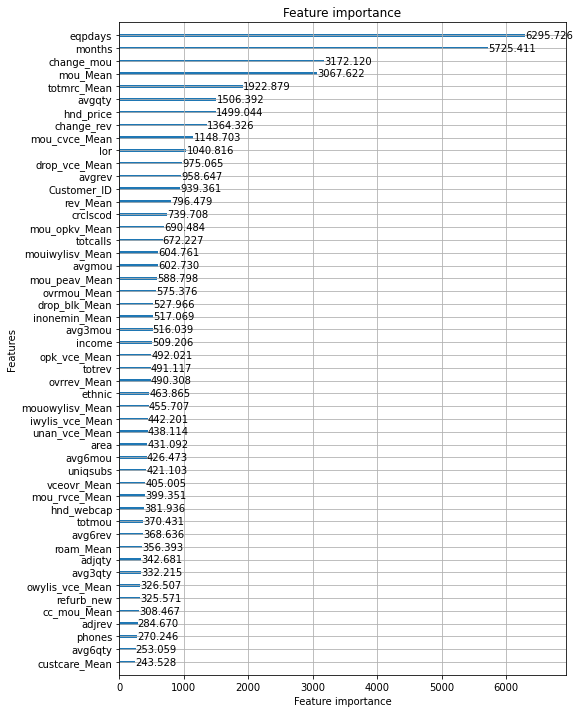

In [16]:
lgbm.plot_importance( model, importance_type="gain", max_num_features=50, figsize=(8, 12) )

### 重要度が高いカラムを抽出

In [ ]:
# 特徴量のカラム名を取得
f_name = model.feature_name_

# 特徴量の値を正規化
f_imp = model.booster_.feature_importance( importance_type='gain' )
f_imp = f_imp / np.sum( f_imp )

# dfを作成
df_imp = pd.DataFrame( {'feature':f_name, 'importance':f_imp} )
df_imp = df_imp.sort_values( 'importance', ascending=False )

# インデックスを振り直す
df_imp = df_imp.reset_index()

display( df_imp )

In [ ]:
# 累積重要度
# 上位22個のデータが，結果の80%を占めている．
def calc_cum_imp():
    tmp_sum = 0
    f_core_th = 0
    cum_imp = []
    for i in range( df_imp['importance'].size ):
        tmp_sum += df_imp['importance'][i]
        cum_imp.append( tmp_sum )

        if tmp_sum < 0.8:
            f_core_th = i+1

    return f_core_th, cum_imp

In [ ]:
f_core_th, cum_imp = calc_cum_imp()

In [ ]:
df_imp['cum_imp'] = cum_imp

In [ ]:
df_imp_core = df_imp[:f_core_th]
df_imp_core

In [ ]:
df_imp_core['feature'].to_csv( '../csv/f_imp_core.csv' )

In [ ]:
def plot_cum_imp():
    plt.rcParams["figure.figsize"] = (24, 10)
    # plt.title( 'Cumulative Feature Importance', fontsize=24 )

    x = df_imp['feature']
    y = df_imp['cum_imp']
    plt.plot( x, y, marker="o", color='black' )
    # plt.hlines( 0.8, 0, 99, "red", linestyles='dashed')
    plt.xticks( range( df_imp['feature'].size ), x, rotation=90, fontsize=10 )
    plt.yticks( [0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=18 )
    plt.ylabel( 'Cumulative feature importance', fontsize=18 )
    plt.show()

In [ ]:
plot_cum_imp()